# Problem Set 2, AKSHAY SINGH: INFX 574C

**Please Note:** This assignment will likely take you a _long_ time, especially if you are new to Python. Start early!

## Introduction to the assignment

For this assignment, you will be using data from the [Progresa program](http://en.wikipedia.org/wiki/Oportunidades), a government social assistance program in Mexico. This program, as well as the details of its impact, are described in the paper "[School subsidies for the poor: evaluating the Mexican Progresa poverty program](http://www.sciencedirect.com/science/article/pii/S0304387803001858)", by Paul Shultz (available on Canvas). Please familiarize yourself with the PROGRESA program before beginning this problem set, so you have a rough sense of where the data come from and how they were generated. If you just proceed into the problem set without understanding Progresa or the data, it will be very difficult!

The goal of this problem set is to implement some of the basic econometric techniques that you are learning in class to measure the impact of Progresa on secondary school enrollment rates. The timeline of the program was:

 * Baseline survey conducted in 1997
 * Intervention begins in 1998, "Wave 1" of data collected in 1998
 * "Wave 2 of data" collected in 1999
 * Evaluation ends in 2000, at which point the control villages were treated. 
 
When you are ready, download the progresa_sample.csv data from Canvas. The data are actual data collected to evaluate the impact of the Progresa program.  In this file, each row corresponds to an observation taken for a given child for a given year. There are two years of data (1997 and 1998), and just under 40,000 children who are surveyed in each year. For each child-year observation, the following variables are collected:

| Variable name | Description|
|---------|---------|
|year	  |year in which data is collected
|sex	  |male = 1|
|indig	  |indigenous = 1|
|dist_sec |nearest distance to a secondary school|
|sc	      |enrolled in school in year of survey|
|grc      |grade enrolled|
|fam_n    |family size|
|min_dist |	min distance to an urban center|
|dist_cap |	min distance to the capital|
|poor     |	poor = 1|
|progresa |treatment =1|
|hohedu	  |years of schooling of head of household|
|hohwag	  |monthly wages of head of household|
|welfare_index|	welfare index used to classify poor|
|hohsex	  |gender of head of household (male=1)|
|hohage   |age of head of household|
|age      |years old|
|folnum	  |individual id|
|village  |	village id|
|sc97	  |schooling in 1997|

In [102]:
#IPython is what you are using now to run the notebook
import IPython
# Numpy is a library for working with Arrays
import numpy as np
# SciPy implements many different numerical algorithms
import scipy as sp
# Pandas makes working with data tables easier
import pandas as pd
# Module for plotting
import matplotlib
# SciKit Learn implements several Machine Learning algorithms
import sklearn

---

##Part 1: Descriptive analysis

### 1.1	Summary Statistics

Present summary statistics (mean and standard deviation) for all of the demographic variables in the dataset (i.e., everything except year, folnum, village). Present these in a single table alphabetized by variable name. Do NOT simply expect the grader to scroll through your output!

In [116]:
#Read from .csv
progresa = pd.read_csv('progresa_sample.csv')

#Drop Na values
progresa = progresa.dropna();

#Populate means
progresa_sum  = pd.DataFrame(progresa.mean())

#Rename 0th column
progresa_sum.rename(columns = {0:'mean'}, inplace = True)

#Populate standard deviation
progresa_sum['std'] = pd.DataFrame(progresa.std())

#Drop columns not needed
progresa_sum = progresa_sum.drop(['year','folnum','village'], axis = 0)
#Sort by lexographic order
progresa_sum.sort_index(inplace = True)

#progresa_trans
progresa_sum

,mean,std
age,11.141369,2.995374
dist_cap,148.747707,77.134043
dist_sec,2.346990,2.111281
fam_n,7.224666,2.329421
grc,4.089494,2.447608
grc97,3.762656,2.449568
hohage,44.262224,11.457772
hohedu,2.853908,2.655106
hohsex,0.927744,0.258914
hohwag,592.782484,791.378223


### 1.2 Differences at baseline?

Are the baseline (1997) demographic characteristics **for the poor**  different in treatment and control villages? Hint: Use a T-Test to determine whether there is a statistically significant difference in the average values of each of the variables in the dataset. Focus only on the data from 1997 for individuals who are poor (i.e., poor=='pobre').

Present your results in a single table with the following columns and 14 (or so) rows:

| Variable name | Average value (Treatment villages) | Average value (Control villages) | Difference (Treat - Control) | p-value |
|------|------|------|------|------|
|Male  |?     |?     |?     |?     |


### 1.3 Interpretation

* A: Are there statistically significant differences between treatment and control villages as baseline? 
* B: Why does it matter if there are differences at baseline?
* C: What does this imply about how to measure the impact of the treatment?

In [130]:
import scipy.stats

# Filter out data for the poor and from '97
progresa_poor = progresa[(progresa['poor']=='pobre') & (progresa['year']==97)]

# Create control group
prog_control = progresa_poor[progresa_poor['progresa'] == 'basal']
# Create treatment group
prog_treatment = progresa_poor[progresa_poor['progresa'] != 'basal']

#Drop non-numeric and id's from dataset
prog_control = prog_control.drop(['progresa','poor','year','folnum','village'], axis = 1)
prog_treatment = prog_treatment.drop(['progresa','poor','year','folnum','village'], axis = 1)

# Create dataframe of mean values from both control and treatment
control_mean = pd.DataFrame(prog_control.mean())
treatment_mean = pd.DataFrame(prog_treatment.mean())

# Join mean values into 
prog_both = pd.DataFrame(pd.concat([treatment_mean, control_mean], axis=1, join='inner'))

# Create new columns and rename older ones
prog_both.columns = ['Average value (Treatment villages)', 'Average value (Control villages)']
prog_both['t-value'] = ""
prog_both['p-value'] = ""
prog_both['difference'] = ""

#Apply ttest for each row in the dataset
for index in range(len(prog_both)):  
    ttest = scipy.stats.ttest_ind(prog_treatment.iloc[::,index:index+1].dropna(),prog_control.iloc[::,index:index+1].dropna())
    prog_both.iloc[index,2:3] = ttest[0]
    prog_both.iloc[index,3:4] = ttest[1]
    prog_both.iloc[index,4:5] = ttest[0] - ttest[1]

#Take only the first value of the tuple returned by ttest
prog_both['t-value'] = prog_both['t-value'].str[0]
prog_both['p-value'] = prog_both['p-value'].str[0]

prog_both = prog_both.drop(['t-value'],axis=1)

#Sort columns lexographically
prog_both.sort_index(ascending = True)

,Average value (Treatment villages),Average value (Control villages),p-value,difference
age,10.785586,10.743825,2.476155e-01,[0.908566840123]
dist_cap,154.492095,151.801472,3.414194e-03,[2.92456839636]
dist_sec,2.400687,2.399648,9.670949e-01,[-0.92584248514]
fam_n,7.302939,7.281032,4.236088e-01,[0.376577954725]
grc,3.733653,3.709214,3.947750e-01,[0.456226728832]
grc97,3.733653,3.709214,3.947750e-01,[0.456226728832]
hohage,44.270717,43.631234,1.925767e-06,[4.76197695267]
hohedu,2.660982,2.726729,2.613239e-02,[-2.25047862816]
hohsex,0.923387,0.925586,4.781232e-01,[-1.18745624168]
hohwag,580.694452,550.207086,2.727661e-04,[3.64002822167]


Interpretation

1.) We see that the p-values are very low for a few variables like dist_cap, hohwag, min_dist, hohage etc. which tells us that there a large statistically significant difference between the control and the baseline even though we might expect them to be close

2.) The assumption here is that randomization was performed correctly. In that case any baseline differences should be a result of that randomization. This might not be so for the progresa data. However, we should also note that the baseline differences are not pointing towards validity of the results of the study

3.) If we assume there is improper randomization due to some flaw in the dataset we'd have to set baseline characteristics in a manner to determine an outcome. They should not be dependent on any evidence of imbalance in the treatment groups

### 1.4 Graphical exploration, part 1

For each level of household head education, compute the average enrollment rate in 1997. Create a scatterplot that shows this relationship. What do you notice?

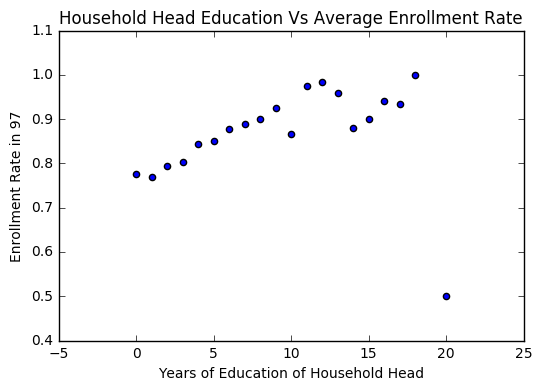

In [132]:
from matplotlib import pyplot as plt

#Filter out year 98
progresa_edu = progresa[progresa['year'] == 97]

#Group by household head education years
progresa_edu = progresa_edu.groupby(['hohedu'],as_index=False).mean()

#Plot area graph using dataframe.plot() using column sc97 denoting enrollment in 97
progresa_edu.plot(x='hohedu',y='sc97',kind='scatter')

#Set title and labels
plt.title('Household Head Education Vs Average Enrollment Rate')
plt.ylabel('Enrollment Rate in 97')
plt.xlabel('Years of Education of Household Head')
plt.show()



We see that the enrollment has a positive relationship with the number of household head education years uptil around 14 years after which it drops down. It increases a bit with a few deviations from the normal till it reaches around 19 years. There is also an outlier at around 0.5 enrollment rate

### 1.5 Graphical exploration, part 2

Create a histogram of village enrollment rates **among poor households in treated villages**, before and after treatment. Specifically, for each village, calculate the average rate of enrollment of poor households in treated villages in 1997, then compute the average rate of enrollment of poor households in treated villages in 1998. Create two separate histograms showing the distribution of these average enrollments rates, one histogram for 1997 and one histogram for 1998. On each histogram, draw a vertical line that intersects the x-axis at the average value (across all households).
* Does there appear to be a difference? Is this difference statistically significant?
* Which D estimator in Schultz (2004) does this approach correspond to?

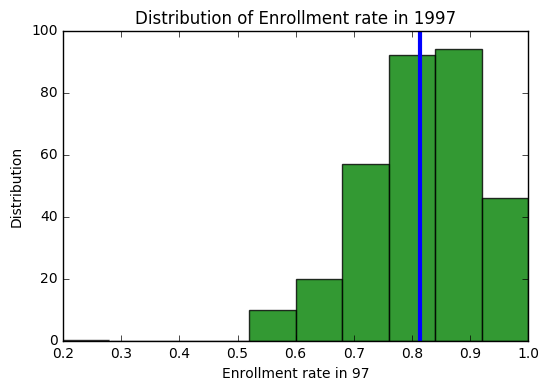

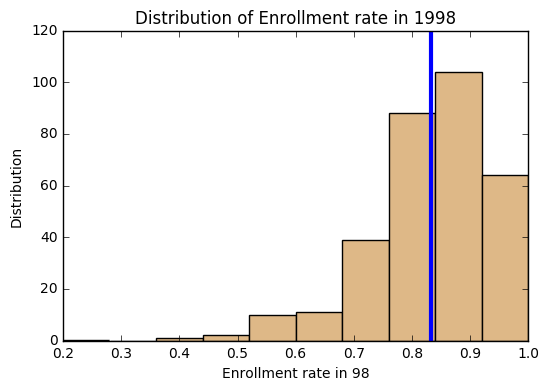

In [147]:
#Filter out data based on poor families
progresa_income = progresa[progresa['poor']=='pobre']

#Filter out data based on year and treatment
progresa_97  = progresa_income[progresa_income['year'] == 97].where(progresa_income['progresa'] == 'basal')
progresa_98  = progresa_income[progresa_income['year'] == 98].where(progresa_income['progresa'] == 'basal')

pre = progresa_97.groupby('village').mean()
post = progresa_98.groupby('village').mean()

# Plot histogram 1
plt.figure(1)

#Specifiy histo characteristics
plt.hist(pre['sc'].values, color = 'g', alpha = 0.8, range = [0.2,1])

#Add vline intersecting the x axis
plt.axvline(pre['sc'].mean(), color = 'b', linestyle = 'solid', linewidth = 3)

#Set labels and title
plt.xlabel('Enrollment rate in 97')
plt.ylabel('Distribution')
plt.title('Distribution of Enrollment rate in 1997')

# Plot historgram 2
plt.figure(2)

#Specifiy histo characteristics
plt.hist(post['sc'].values, color = 'burlywood', range = [0.2,1])

#Add vline intersecting the x axis
plt.axvline(post['sc'].mean(), color = 'b', linestyle = 'solid', linewidth = 3)

#Set labels and title
plt.xlabel('Enrollment rate in 98')
plt.ylabel('Distribution')
plt.title('Distribution of Enrollment rate in 1998')

plt.show()

There seems to be a difference in the average enrollment rates. Let's see that difference

In [148]:
# Find the difference
rate_diff = post['sc'].mean() - pre['sc'].mean()
print(rate_diff)

0.019984378946272252


Let us check if this difference is statistically significant.

In [150]:
# ttest
t_test = stats.ttest_ind(post['sc'].dropna(), pre['sc'].dropna())
t_test[1]

0.010587739721624679

As we can see the p-value is 0.0105 which indicates this difference is statistically significant. We can also see the difference in the average values of enrollment rate in '97 and '98 throught the historgram as well as the calculation we performed.

## Part 2: Measuring Impact

### 2.1 Simple differences: T-test

Start out by estimating the impact of Progresa using "simple differences." Restricting yourself to data from 1998 (after treatment).
* calculate the average enrollment rate among **poor** households in the Treatment villages and the average enrollment rate among **poor** households in the control villages.
* Which difference estimator in Schultz (2004) does this approach correspond to?
* Use a t-test to determine if this difference is statistically significant. What do you conclude?

In [153]:
# Filter data for year 98 and poor households with treatement and control group conditions
control_group =   progresa[(progresa['year'] == 98) & (progresa['poor'] == 'pobre') & (progresa['progresa'] != 'basal')]
treatment_group = progresa[(progresa['year'] == 98) & (progresa['poor']  == 'pobre') & (progresa['progresa'] == 'basal')]

# average enrollment rate in treatment villages
treatment_average = treatment_group['sc'].mean()
# average enrollment rate among poor households in control villages
control_average = control_group['sc'].mean()

progresa_ttest = scipy.stats.ttest_ind(treatment_group['sc'].dropna(), control_group['sc'].dropna())

# tabulating results
table_significant = pd.DataFrame.from_items([('Treatment Group Enrollment Mean', [treatment_average]), 
                        ('Control Group Enrollment Mean', [control_average]),
                        ('Difference in rates', [treatment_average - control_average]),
                        ('t-value', [progresa_ttest[0]]), 
                        ('p-value', [progresa_ttest[1]])])

table_significant

,Treatment Group Enrollment Mean,Control Group Enrollment Mean,Difference in rates,t-value,p-value
0,0.849257,0.810923,0.038334,8.10165,5.656456e-16


The p value is lesser than 0.05 which means that the difference is not random but is statistically significant

Looking at just the difference treatment villages have a higher rate of enrollment in 1998 as compared to the control villages.

### 2.2 Simple differences: Regression

Estimate the effects of Progresa on enrollment using a regression model, by regressing the 1998 enrollment rates **of the poor** on treatment assignment. Discuss the following:

* Based on this model, how much did Progresa increase the likelihood of a child enrolling?
* How does your regression estimate compare to your t-test estimate from part 2.1?
* Based on this regression model, can we reject the null hypothesis that the treatment effects are zero? 
* What is the counterfactual assumption underlying this regression?

In [159]:
import statsmodels.formula.api as smf

# Filter out non poor and year 97
progresa_post = progresa[(progresa['poor'] == 'pobre') & (progresa['year'] == 98)]

# Linear model
progresa_regression = smf.ols(formula = 'sc ~ progresa', data = progresa_post).fit()

# Get summary of the regression model
progresa_regression.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     65.64
Date:                Thu, 26 Jan 2017   Prob (F-statistic):           5.66e-16
Time:                        13:44:06   Log-Likelihood:                -11171.
No. Observations:               26155   AIC:                         2.235e+04
Df Residuals:                   26153   BIC:                         2.236e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept             0.8109      0.004    217.190      0.000         0.804     0.818
progresa[T.basal]     0.0383      0.005      8.102      0.000         0.029     0.048
==============================================================================
Omnibus:                     7487.800   Durbin-Watson:                   1.734
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15756.374
Skew:                          -1.796   Prob(JB):                         0.00
Kurtosis:                       4.245   Cond. No.                         3.02
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [160]:
#Look at the standard error
progresa_regression.bse

Intercept            0.003734
progresa[T.basal]    0.004732
dtype: float64

Answer

a.) From the standard error of the regression model we can see that the intercept is 0.0037 which means that the probability of a child getting enrolled in school has increased by 0.0037 times.

b.) Our t-test estimate from 2.1 has the same t-value as the T statistic of the regression model. The p-values are also the same which indicate that our estimates from 2.1 were correct and equal to esitimates from 2.2

c.) Our p-value is very small and statistically significant. This means we can reject the null hypothesis and say that we're 95% confident that the progresa treatment is affecting enrollment rates. 

d.) We're assuming that without treatment the average enrollment rates in 98 would be same as the control group. 

### 2.3 Multiple Regression

Re-run the above regression estimated but this time include a set of control variables. Include, for instance, age, distance to a secondary school, gender, education of household head, indigenous, etc.

* How do the controls affect the point estimate of treatment effect?
* How do the controls affect the standard error on the treatment effect? 
* How do you interpret the differences (or similarities) between your estimates of 2.2 and 2.3?

In [161]:
# Filter out non poor and year 97
progresa_post_multi = progresa[(progresa['poor'] == 'pobre') & (progresa['year'] == 98)]

# Linear model
progresa_regression_multi = smf.ols(formula = 'sc ~ progresa + dist_sec + hohedu + welfare_index + indig + dist_cap + min_dist', data = progresa_post_multi).fit()

# Get summary of the regression model
progresa_regression_multi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     102.1
Date:                Thu, 26 Jan 2017   Prob (F-statistic):          5.95e-148
Time:                        13:44:19   Log-Likelihood:                -10852.
No. Observations:               26155   AIC:                         2.172e+04
Df Residuals:                   26147   BIC:                         2.178e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
Intercept             0.8098      0.015     53.204      0.000         0.780     0.840
progresa[T.basal]     0.0352      0.005      7.494      0.000         0.026     0.044
dist_sec             -0.0086      0.001     -8.005      0.000        -0.011    -0.007
hohedu                0.0155      0.001     17.053      0.000         0.014     0.017
welfare_index        -0.0001      2e-05     -7.046      0.000        -0.000    -0.000
indig                 0.0200      0.006      3.588      0.000         0.009     0.031
dist_cap              0.0001   4.32e-05      3.410      0.001      6.26e-05     0.000
min_dist              0.0004   7.47e-05      5.637      0.000         0.000     0.001
==============================================================================
Omnibus:                     7116.832   Durbin-Watson:                   1.761
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14482.554
Skew:                          -1.727   Prob(JB):                         0.00
Kurtosis:                       4.165   Cond. No.                     4.65e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.65e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [162]:
progresa_regression_multi.bse

Intercept            0.015220
progresa[T.basal]    0.004694
dist_sec             0.001080
hohedu               0.000908
welfare_index        0.000020
indig                0.005564
dist_cap             0.000043
min_dist             0.000075
dtype: float64

a.) We can see that our point estimate has reduced from 0.0383 to 0.0352. So the progresa variable was actually overestimating the treatment effect. Adding more control variables also further highlighted their impact rather than just progresa.

b.) We can see that the SE rate has decreased. This further supplements our conclusion that adding more variables made our treatment variable more accurate

c.) One significant difference is seen in the R-squared value. It has increased 9 times and thus signifies that adding more controls to our model has increased it's performance considerably.

### 2.4 Difference-in-Difference, version 1 (tabular)

Thus far, we have computed the effects of Progresa by estimating the difference in 1998 enrollment rates across villages. An alternative approach would be to compute the treatment effect using a difference-in-differences framework.

Begin by estimating the average treatment effects of the program for poor households using data from 1997 and 1998. Specifically, calculate the difference (between 1997 and 1998) in enrollment rates among poor households in treated villages; then compute the difference (between 1997 and 1998) in enrollment rates among poor households in treated villages. The difference between these two differences is your estimate.

* What is your estimate of the impact, and how does it compare to your earlier (simple difference) results?
* What is the counterfactual assumption underlying this estimate? 


In [164]:
# Calculate means before and after treatment

#Filter for year 97
before_cont = progresa[(progresa['poor'] == 'pobre') & (progresa['year']  == 97) & (progresa['progresa'] != 'basal')].mean()['sc']
before_treat =  progresa[(progresa['poor']  == 'pobre') & (progresa['year']  == 97) & (progresa['progresa']== 'basal')].mean()['sc']

#Filter for year 98
after_treat = progresa[(progresa['poor']  == 'pobre') & (progresa['year']  == 98) & (progresa['progresa'] == 'basal')].mean()['sc']
after_cont = progresa[(progresa['poor']  == 'pobre') & (progresa['year']  == 98) & (progresa['progresa'] != 'basal')].mean()['sc']

#Calculate differences
diff_control =   after_cont - before_cont
diff_treatment = after_treat - before_treat
Diff_in_SC =    diff_treatment - diff_control

# Tabular format
tabular = {'Before Values':pd.Series([before_cont, before_treat, diff_control], index = ['Control', 'Treatment', 'Difference']),
       'After Values':pd.Series([after_cont, after_treat, diff_treatment], index = ['Control', 'Treatment', 'Difference']),}

pd.DataFrame(tabular)

,After Values,Before Values
Control,0.810923,0.815066
Treatment,0.849257,0.822697
Difference,0.026561,-0.004142


In [165]:
print(Diff_in_SC)

0.0307029732307


a.) We can see that average enrollment rate has improved by 0.0307

b.) It is the same assumption we made earlier. In absence of treatment the enrollment rates should be the same as the control group

### 2.5 Difference-in-Difference, version 1 (regression)

Now use a regression specification to estimate the average treatment effect of the program (on the poor) in a difference-in-differences framework. Include at least 5 control variables.

* What is your estimate of the impact of Progresa? Be very specific in interpreting your coefficients and standard errors, and make sure to specify exactly what units you are measuring and estimating.
* How do these estimates of the treatment effect compare to the estimates based on the simple difference?
* How do these estimates compare to the difference-in-difference estimates from 2.4 above? What accounts for these differences?
* What is the counterfactual assumption underlying this regression? 

In [175]:
# Filter by poor
progresa_diff = progresa[(progresa['poor'] == 'pobre')]

#Create column that singifies if the year is 98 to take into account the effect
progresa_diff['effect'] = progresa_diff['year'] == 98

# Fit difference seeing the effect of our added variable effect
progresa_model = smf.ols(formula = 
  'sc ~ progresa + dist_sec + hohedu + welfare_index + indig + dist_cap + min_dist + effect + progresa*effect', data = progresa_diff).fit()

progresa_model.summary()

C:\Users\singhak\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     156.9
Date:                Thu, 26 Jan 2017   Prob (F-statistic):          1.17e-294
Time:                        14:54:38   Log-Likelihood:                -24759.
No. Observations:               56893   AIC:                         4.954e+04
Df Residuals:                   56883   BIC:                         4.963e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------
Intercept                            0.8337      0.011     76.936      0.000         0.813     0.855
progresa[T.basal]                    0.0047      0.004      1.075      0.283        -0.004     0.013
effect[T.True]                      -0.0056      0.005     -1.101      0.271        -0.016     0.004
progresa[T.basal]:effect[T.True]     0.0305      0.006      4.696      0.000         0.018     0.043
dist_sec                            -0.0080      0.001    -10.740      0.000        -0.009    -0.007
hohedu                               0.0154      0.001     24.521      0.000         0.014     0.017
welfare_index                       -0.0002   1.39e-05    -11.948      0.000        -0.000    -0.000
indig                                0.0223      0.004      5.806      0.000         0.015     0.030
dist_cap                             0.0001   2.99e-05      4.772      0.000      8.41e-05     0.000
min_dist                             0.0004   5.17e-05      7.463      0.000         0.000     0.000
==============================================================================
Omnibus:                    14408.116   Durbin-Watson:                   1.414
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28076.831
Skew:                          -1.659   Prob(JB):                         0.00
Kurtosis:                       3.912   Cond. No.                     4.94e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.94e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [168]:
#Standard errors
progresa_model.bse

Intercept                           0.010837
progresa[T.basal]                   0.004405
effect[T.True]                      0.005114
progresa[T.basal]:effect[T.True]    0.006486
dist_sec                            0.000746
hohedu                              0.000629
welfare_index                       0.000014
indig                               0.003841
dist_cap                            0.000030
min_dist                            0.000052
dtype: float64

a.) To estimate the impact of Progresa we've taken the treatment variable 'progresa' in conjuction with a variable 'effect' that show's the interaction effect of the treatment and the year '98. The value of the parameter is 0.0305

b.) Our interaction variable is more statistically significant in this difference of difference method than the 'progresa' variable was in the simple differences method. This shows that we over-estimated the impact of that variable alone without taking into account our counterfactual.

c.) Problem 2.4 yielded a difference of 0.0307 and didn't account for all the other control variables which we've now used. This indicates that the impact of the variable 'progresa' decreased due to the other variables used. 

d.) The counterfactual assumption  is that in the absence of treatment and controls, over a particular time (97-98), the rate of enrollment in the treatment villages would have been equal to the rate of enrollment in control villages.

### 2.6 Difference-in-Difference, version 2

In the previous problem, you estimated a difference-in-differences model that compared changes in enrollment rates over time across treatment and control villages. An alternative approach would be to compare enrollment rates in 1998 between poor and non-poor across treatment and control villages. 

* How would we estimate this version of the treatment effects in a regression model? 
* What is the counterfactual assumption underlying this regression?
* How do these treatment effects compare to the estimates above?
* Discuss some possible explanations for differences or similarities 

In [174]:
# Filter by year
progresa_diff_2 = progresa[(progresa['year'] == 98)]

#Create column that singifies if the people are poor to take into account its effect
progresa_diff_2['effect'] = progresa_diff_2['poor'] == 'pobre'

# Fit difference seeing the effect of our added variable effect
progresa_model_2 = smf.ols(formula = 
  'sc ~ progresa + dist_sec + hohedu + welfare_index + indig + dist_cap + min_dist + progresa*effect', data = progresa_diff_2).fit()

progresa_model_2.summary()

C:\Users\singhak\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.029
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     102.2
Date:                Thu, 26 Jan 2017   Prob (F-statistic):          2.44e-189
Time:                        14:54:03   Log-Likelihood:                -13066.
No. Observations:               30665   AIC:                         2.615e+04
Df Residuals:                   30655   BIC:                         2.623e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------
Intercept                            0.7739      0.019     40.217      0.000         0.736     0.812
progresa[T.basal]                    0.0217      0.011      1.923      0.055        -0.000     0.044
effect[T.True]                       0.0061      0.010      0.585      0.558        -0.014     0.026
progresa[T.basal]:effect[T.True]     0.0140      0.012      1.145      0.252        -0.010     0.038
dist_sec                            -0.0090      0.001     -8.821      0.000        -0.011    -0.007
hohedu                               0.0160      0.001     19.780      0.000         0.014     0.018
welfare_index                       -0.0001   1.85e-05     -5.449      0.000        -0.000 -6.47e-05
indig                                0.0201      0.005      3.786      0.000         0.010     0.031
dist_cap                             0.0002   4.11e-05      4.732      0.000         0.000     0.000
min_dist                             0.0004      7e-05      5.368      0.000         0.000     0.001
==============================================================================
Omnibus:                     7895.047   Durbin-Watson:                   1.769
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15519.102
Skew:                          -1.671   Prob(JB):                         0.00
Kurtosis:                       3.985   Cond. No.                     7.81e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.81e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [170]:
#Standard error
progresa_model_2.bse

Intercept                           0.019242
progresa[T.basal]                   0.011280
effect[T.True]                      0.010405
progresa[T.basal]:effect[T.True]    0.012238
dist_sec                            0.001020
hohedu                              0.000811
welfare_index                       0.000019
indig                               0.005313
dist_cap                            0.000041
min_dist                            0.000070
dtype: float64

a.) We would add a binary effect variable to signify whether the family was poor or not. We would then combine it with the interaction variable in our multiple regression

b.) The counterfactual assumption is that in the absence of treatment, the rate of enrollment, for the poor as well as the non-poor would be the same as the enrollment for the control group

c.) The treatment effects are different as we can see the R-squared value has increased from 0.024 to 0.029. The effect of the poverty variable in case of poor and non-poor households is still statistically significant even though it is on the whole insignificant.

d.) Our present model is the same as the previous model given that we've added our own interaction variable in both the cases. On their own they might not be significant but we check their effects in conjuction with the 'progresa' variable. 

The difference however is that time is statistically significant in conjuction with the treatment variable in the previous model whereas the effect of poverty isn't statistically significant in this model, on it's own or in conjuction with the treatment variable, as we can see from p-values. 

### 2.7 Spillover effects (extra credit)

Thus far, we have focused on the impact of PROGRESA on poor households. Repeat your analysis in 2.5, using a double-difference regression to estimate the impact of PROGRESA on non-poor households. In other words, compare the difference in enrollments between 1997 and 1998 for non-poor households in treatment villages with the difference in enrollments between 1997 and 1998 for non-poor households in control villages.

* A: Describe one or two reasons why PROGRESA might have impacted non-poor households.
* B: Do you observe any impacts of PROGRESA on the non-poor?
* C: What is the identifying assumption that you are using to estimate the impact of PROGRESA on non-poor households.

In [178]:
# Filter by poor
progresa_diff_3 = progresa[(progresa['poor'] == 'no pobre')]

#Create column that singifies if the year is 98 to take into account the effect
progresa_diff_3['effect'] = progresa_diff_3['year'] == 98

# Fit difference seeing the effect of our added variable effect
progresa_model_3 = smf.ols(formula = 
  'sc ~ progresa + dist_sec + hohedu + welfare_index + indig + dist_cap + min_dist + progresa*effect', data = progresa_diff_3).fit()

progresa_model_3.summary()

C:\Users\singhak\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     sc   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     47.50
Date:                Thu, 26 Jan 2017   Prob (F-statistic):           1.22e-84
Time:                        14:57:29   Log-Likelihood:                -5117.0
No. Observations:               10229   AIC:                         1.025e+04
Df Residuals:                   10219   BIC:                         1.033e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------
Intercept                            0.6250      0.032     19.826      0.000         0.563     0.687
progresa[T.basal]                    0.0248      0.011      2.290      0.022         0.004     0.046
effect[T.True]                       0.0174      0.013      1.380      0.168        -0.007     0.042
progresa[T.basal]:effect[T.True]    -0.0049      0.016     -0.299      0.765        -0.037     0.027
dist_sec                            -0.0152      0.002     -7.389      0.000        -0.019    -0.011
hohedu                               0.0175      0.001     13.972      0.000         0.015     0.020
welfare_index                     5.422e-05    3.3e-05      1.642      0.101     -1.05e-05     0.000
indig                                0.0175      0.012      1.441      0.150        -0.006     0.041
dist_cap                             0.0005   8.87e-05      6.099      0.000         0.000     0.001
min_dist                         -4.298e-05      0.000     -0.316      0.752        -0.000     0.000
==============================================================================
Omnibus:                     1814.569   Durbin-Watson:                   1.493
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3000.703
Skew:                          -1.327   Prob(JB):                         0.00
Kurtosis:                       2.967   Cond. No.                     7.26e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.26e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [172]:
#sTANDARD ERROR
progresa_model_3.bse

Intercept                           0.010837
progresa[T.basal]                   0.004405
effect[T.True]                      0.005114
progresa[T.basal]:effect[T.True]    0.006486
dist_sec                            0.000746
hohedu                              0.000629
welfare_index                       0.000014
indig                               0.003841
dist_cap                            0.000030
min_dist                            0.000052
dtype: float64

a.) Progresa seems to have an impact on non-poor households as well. It might be attributed to the fact that progresa program as a whole is an economic stimulus and that, even though those households are poor they might seek to better themselves witht the incentives from such a program

b.) We can see that the interaction variable is statistically insignificant when it comes to the non-poor as it's p-value is way higher than 0.05. Thus we can say it had no effect on non-poor households.

### 2.8 Summary

Based on all the analysis you have undertaken to date, do you thik that Progresa had a causal impact on the enrollment rates of poor households in Mexico?

In the single difference model we saw that the impact of the progresa program on enrollment rates was significant at 0.038. We also saw through further analyses that we over-estimated the effect of the treatment variable and once other control variables were introduced it's impact lessened. 

However, an interaction variable made by the conjunction of the treatment variable plus time was seen to be statistically significant even when 'time' and 'progresa' weren't significant on their own. What we were seeing was the effect of the progresa program over a period of time, and it was signficant. 

We did the same for the treatment and poverty variables but there was no significance to be found which supplements our conclusion that progresa over time helped increase enrollment rates. 